In [1]:
import argparse
import os
import numpy as np
import math

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable
from tqdm import tqdm_notebook

import torch.nn as nn
import torch.nn.functional as F
import torch
import shutil
import time

os.makedirs('images_ensemble_mnist10_classifier_small', exist_ok=True)
shutil.rmtree('images_ensemble_mnist10_classifier_small')
os.makedirs('images_ensemble_mnist10_classifier_small', exist_ok=True)


/home/roy206/.conda/envs/cent7/2020.11-py38/NWRGAE/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def get_seq_model_shapes(seq_model, input_shape, seq_model_name = 'seq_model'):
    input_tensor = torch.zeros(*input_shape)
    output = input_tensor
    print("\n{} Layers:\n".format(seq_model_name))
    
    for i, ly in enumerate(seq_model):
        output = seq_model[i](output)
        print('Layer Block {}: {}, out shape: {}'.format(i, ly, output.shape))
    return output

def verify_string_args(string_arg, string_args_list):
    if string_arg not in string_args_list:
        raise ValueError("Argument '{}' not available in {}".format(string_arg, string_args_list))

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)

def convT_block(nf_in, nf_out, stride = 2, padding = 1,norm='no_norm', act=None, kernel_size=4):
    block = [nn.ConvTranspose2d(nf_in, nf_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=True )]
    if act is not None:
        block.append(act)
    return block

def conv_block(nf_in, nf_out, stride = 2, padding = 2, fmap_shape=[10,10], norm=None, act=None, kernel_size=5):
    block = [nn.Conv2d(nf_in, nf_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=True )]
    if norm == 'layer_norm':
        block.append(nn.LayerNorm([nf_out]+fmap_shape))
    elif norm == 'spectral_norm':
        block[-1] = torch.nn.utils.spectral_norm(block[-1])
    if act is not None:
        block.append(act)
    #block.append(nn.LeakyReLU(0.2, inplace=True))
    #block.append(GaussianNoise(normal_std_scale=0.7))
    return block


def linear_block(nf_in, nf_out, norm='no_norm',  act=None):
    block = [nn.Linear(nf_in, nf_out)]
    if norm == 'layer_norm':
        block.append(nn.LayerNorm([nf_out]))
    elif norm == 'spectral_norm':
        block[-1] = torch.nn.utils.spectral_norm(block[-1])
    if act is not None:
        block.append(act)
    return block



In [3]:
class arg_parser_subst():
    def __init__(self):
        self.n_epochs = 500 
        self.batch_size = 100
        self.batch_size_g = 100
        self.lr = 0.0002 
        self.b1 = 0.5 
        self.b2 = 0.999 
        self.n_cpu = 12 
        self.latent_dim = 100 
        self.img_size = 32
        self.channels = 3
        self.sample_interval = 400 
        self.n_paths_G = 10 # number of generators
        self.classifier_para = 0.001
        self.classifier_para_g = 0.001
        

In [4]:
opt = arg_parser_subst()

In [37]:
img_shape = (opt.channels, opt.img_size, opt.img_size)
cuda = True if torch.cuda.is_available() else False



class Generator(nn.Module):
    def __init__(self, 
                 architecture = 'cnn', 
                 nf=128, 
                 kernel_size=4, 
                 latent_dim = 100, 
                 nc = 3,
                 print_shapes=False,
                 norm = 'no_norm'
                ):
        
        super(Generator, self).__init__()
        
        self.img_size = 32
        self.architecture = architecture
        self.nf = nf
        self.kernel_size = kernel_size
        self.latent_dim = latent_dim
        self.nc = nc
        self.norm = norm
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        
        
        modules = nn.ModuleList()

        for _ in range(opt.n_paths_G):
            
            gen_layers = []

            if architecture == 'cnn' or architecture == 'cnn_short':
                first_map_shape = 8
                gen_layers += linear_block(self.latent_dim, nf*2*first_map_shape*first_map_shape, norm='no_norm', act=nn.ReLU(True))
                gen_layers += Reshape(-1, nf*2, first_map_shape, first_map_shape),
                gen_layers += convT_block(nf*2, nf, stride=2, padding=1, norm=self.norm, act=nn.ReLU(True)) 
                gen_layers += convT_block(nf, nc, stride=2, padding=1, norm='no_norm', act=nn.Tanh())  

            elif (architecture == 'cnn_long'):
                first_map_shape = 3
                gen_layers += linear_block(self.latent_dim, nf*4*first_map_shape*first_map_shape, norm='no_norm', act=nn.ReLU(True))
                gen_layers += Reshape(-1, nf*4, first_map_shape, first_map_shape),
                gen_layers += convT_block(nf*4, nf*2, stride=2, padding=1, norm=self.norm, act=nn.ReLU(True)) 
                gen_layers += convT_block(nf*2, nf, stride=2, padding=0, norm=self.norm, act=nn.ReLU(True))  
                gen_layers += convT_block(nf, nc, stride=2, padding=1, norm='no_norm',  act=nn.Tanh())  

            else:
                raise ValueError('Architecture {} not implemented!'.format(architecture))

            module = nn.Sequential(*gen_layers)
            modules.append(module)
            
        self.paths = modules

    def forward(self, z):
        img = []
        for path in self.paths:
            img.append(path(z).view(img.size(0), *img_shape))
        img = torch.cat(img, dim=0)
       
        return img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        # self.fc1 = nn.Linear(int(np.prod(img_shape)), 512)
        # self.lr1 = nn.LeakyReLU(0.2, inplace=True)
        # self.fc2 = nn.Linear(512, 256)
        # self.lr2 = nn.LeakyReLU(0.2, inplace=True)
        
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(4096, 100)
        
        modules = nn.ModuleList()
        
        modules.append(nn.Sequential(
            nn.Linear(100, 1),
            nn.Sigmoid(),
                ))
        modules.append(nn.Sequential(
            nn.Linear(100, opt.n_paths_G),
                ))
        self.paths = modules
    
    def forward(self, x):
        
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = self.bn1(x)
        x = F.leaky_relu(self.conv2(x), 0.2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), 0.2)
        x = self.bn3(x)
        x = x.view(100, -1)
        x = self.fc1(x)
        
        
        validity = self.paths[0](x)
        classifier = F.log_softmax(self.paths[1](x), dim=1)

        return validity, classifier

        
#         img_flat = img.view(img.size(0), -1)
#         img_flat = self.lr2(self.fc2(self.lr1(self.fc1(img_flat))))
        
#         validity = self.paths[0](img_flat)

        
        # return validity, classifier

adversarial_loss = torch.nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

if cuda:
    generator.cuda()
    discriminator.cuda()
    adversarial_loss.cuda()


In [26]:
# Configure data loader
# os.makedirs('data/fmnist', exist_ok=True)
# dataloader = torch.utils.data.DataLoader(
#     datasets.FashionMNIST('data/fmnist', train=True, download=True,
#                    transform=transforms.Compose([
#                        transforms.ToTensor(),
#                        transforms.Normalize([.5],[.5])
#                    ])),
#     batch_size=opt.batch_size, shuffle=True)

dataloader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data/fmnist', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize([.5],[.5])
                   ])),
    batch_size=opt.batch_size, shuffle=True)




Files already downloaded and verified


In [7]:
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [8]:

%matplotlib inline
def show(img):
    npimg = img.detach().numpy()
    plt.figure(figsize = (opt.n_paths_G//2,opt.n_paths_G//2))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')



[Epoch 0/500] [Batch 499/500] [D loss: 7.133331] [G loss: 6.630078] [C loss 1: 0.023360] [C loss 2: 0.023360] [Acc: 10.30%] 	 Time Interv: 102.106780


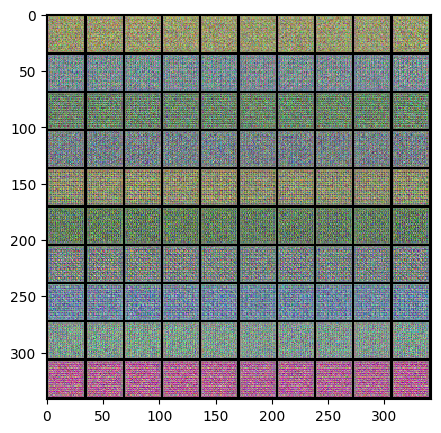

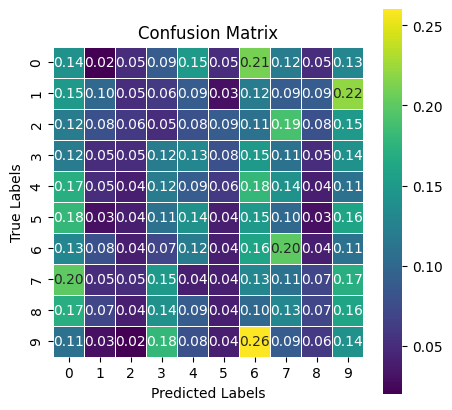

[Epoch 5/500] [Batch 499/500] [D loss: 7.132941] [G loss: 6.629987] [C loss 1: 0.023355] [C loss 2: 0.023355] [Acc: 10.27%] 	 Time Interv: 101.191546


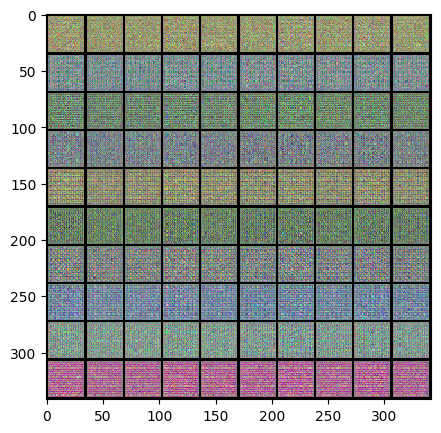

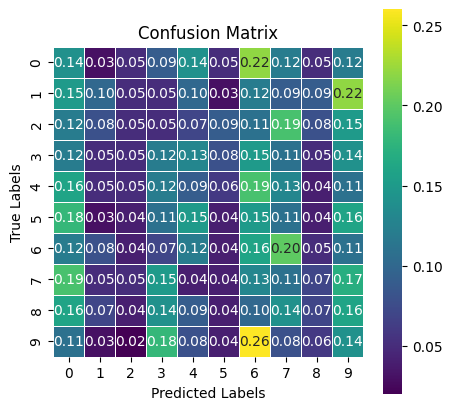

[Epoch 10/500] [Batch 499/500] [D loss: 7.134270] [G loss: 6.628657] [C loss 1: 0.023362] [C loss 2: 0.023362] [Acc: 10.25%] 	 Time Interv: 101.033586


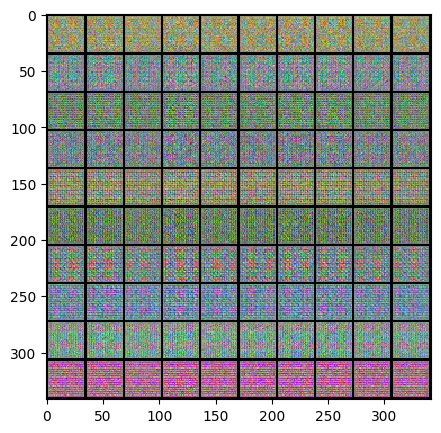

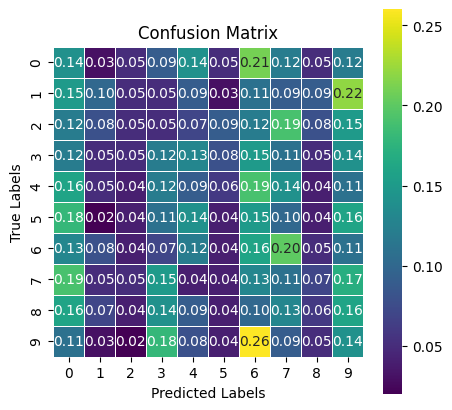

[Epoch 15/500] [Batch 499/500] [D loss: 7.134067] [G loss: 6.629186] [C loss 1: 0.023350] [C loss 2: 0.023350] [Acc: 10.33%] 	 Time Interv: 100.723742


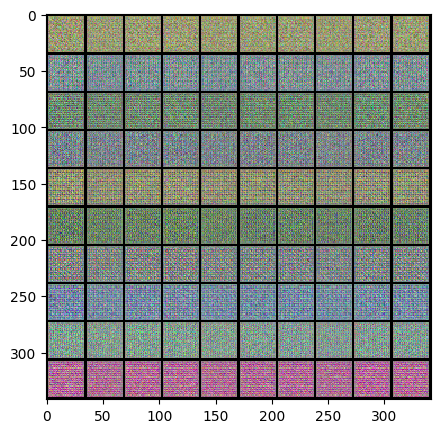

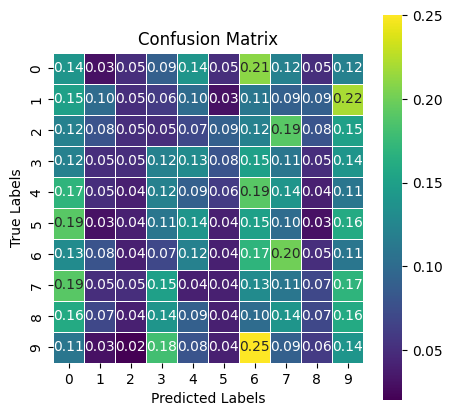

[Epoch 40/500] [Batch 499/500] [D loss: 7.135430] [G loss: 6.626286] [C loss 1: 0.023360] [C loss 2: 0.023360] [Acc: 10.26%] 	 Time Interv: 100.047999


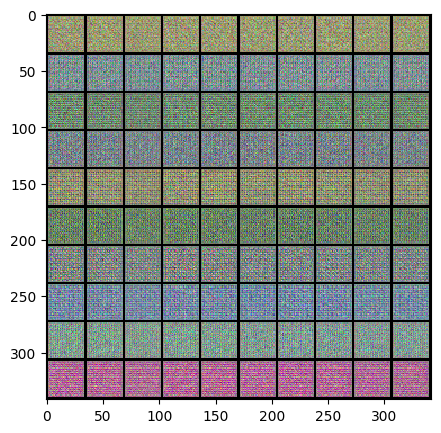

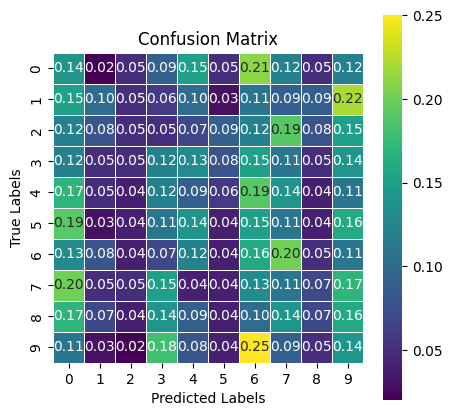

[Epoch 60/500] [Batch 499/500] [D loss: 7.135809] [G loss: 6.626324] [C loss 1: 0.023364] [C loss 2: 0.023364] [Acc: 10.22%] 	 Time Interv: 99.448807


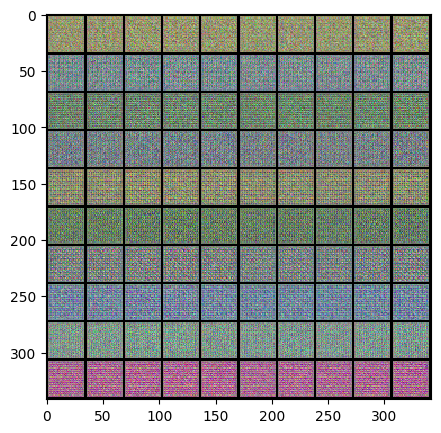

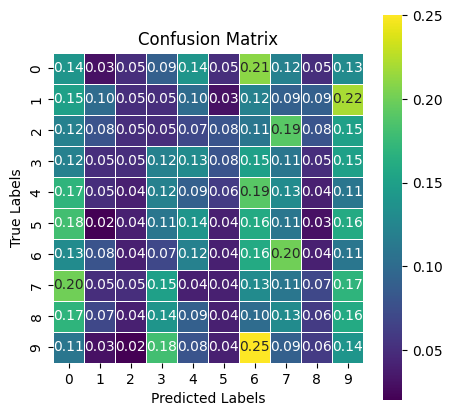

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For visualizing the confusion matrix

for epoch in range(opt.n_epochs):

    start = time.time()
    all_targets = []
    all_predictions = []
    
    epoch_start = 0
    
    g_loss_epoch = 0
    d_loss_epoch = 0
    c_loss_1_epoch = 0
    c_loss_2_epoch = 0
    
    correct_predictions = 0
    total_predictions = 0

    num_batches = len(dataloader)
    
    for i, (imgs, _) in enumerate(dataloader):
        
        valid = Variable(Tensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        real_imgs = Variable(imgs.type(Tensor))

        # -----------------------------------------------------
        #  Train Generator 
        # -----------------------------------------------------

        optimizer_G.zero_grad()

        z = Variable(Tensor(np.random.normal(0, 1, (opt.batch_size_g, opt.latent_dim))))
        g_loss = 0 
        c_loss_1 = 0 
        
        for k in range(opt.n_paths_G):

            gen_imgs = generator.paths[k](z)
            validity, classifier = discriminator(gen_imgs)
            
            
            g_loss += adversarial_loss(validity, valid)

            target = Variable(Tensor(imgs.size(0)).fill_(k), requires_grad=False)
            target = target.type(torch.cuda.LongTensor)
            
            c_loss_1 += F.nll_loss(classifier, target) * opt.classifier_para_g

            _, predicted = torch.max(classifier.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()
    
            # Collect all targets and predictions for confusion matrix
            all_targets.extend(target.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
        
        g_loss_epoch += g_loss
        c_loss_1_epoch += c_loss_1       
        g_loss = g_loss + c_loss_1
        
        g_loss.backward()
        optimizer_G.step()
        
        # ------------------------------------------------------------------------
        #  Train Discriminator and Classifier (WE CALL THIS STAGE PHASE 2)
        # ------------------------------------------------------------------------

        optimizer_D.zero_grad()

        d_loss = 0 #adversarial loss for discrimination to be applied to the discriminator
        c_loss_2 = 0 #classification loss to be applied to the classifier
        
        #loss of the discriminator with real images
        validity, classifier = discriminator(real_imgs)
        real_loss = adversarial_loss(validity, valid)
        
        temp = [] #variable to store images for plot
        
        #again we iterate over each of the generators
        for k in range(opt.n_paths_G):

            # generates a batch of images with generator k
            gen_imgs = generator.paths[k](z).view(imgs.shape[0], *img_shape)
            temp.append(gen_imgs[0:10, :])

            #again we measure the outputs of the discriminator and the classifier 
            validity, classifier = discriminator(gen_imgs.detach())

            #loss of the discriminator with fake images
            fake_loss = adversarial_loss(validity, fake)
            
            #sums up the fake and true losses
            d_loss += (real_loss + fake_loss) / 2

            #again we calculate the loss of the classifier. Note that it is calculated...
            #...in exactly the same way as before, but only after the...
            #...generator has already had its weights updated in PHASE 1.
            #reminder: opt.classifier_para is just a multiplicative constant of the loss
            target = Variable(Tensor(imgs.size(0)).fill_(k), requires_grad=False)
            target = target.type(torch.cuda.LongTensor)
            c_loss_2 += F.nll_loss(classifier, target) * opt.classifier_para
        
        #images for plot
        plot_imgs = torch.cat(temp, dim=0)

        #again, we accumulate the losses to visualize the total for the epoch
        d_loss_epoch += d_loss
        c_loss_2_epoch += c_loss_2
        
        #we add both losses into the same variable 
        d_loss = d_loss + c_loss_2
        #jointly apply the gradients to the layers of the discriminator and classifier
        d_loss.backward()
        optimizer_D.step()
    
    #printing training information
    interval = time.time() - start
    
    if (epoch < 20 and epoch % 5 == 0) or (epoch > 20 and epoch % 20 == 0):
        
        # print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss 1: %f] [C loss 2: %f] \t Time Interv: %f"
        #        % (epoch, opt.n_epochs, i, num_batches, d_loss_epoch.item()/num_batches, g_loss_epoch.item()/num_batches, 
        #           c_loss_1_epoch.item()/num_batches, c_loss_2_epoch.item()/num_batches, interval))

        classification_accuracy = 100.0 * correct_predictions / total_predictions

        print ("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f] [C loss 1: %f] [C loss 2: %f] [Acc: %.2f%%] \t Time Interv: %f"
            % (epoch, opt.n_epochs, i, num_batches, d_loss_epoch.item()/num_batches, g_loss_epoch.item()/num_batches, 
                c_loss_1_epoch.item()/num_batches, c_loss_2_epoch.item()/num_batches, classification_accuracy, interval))

        show(make_grid(plot_imgs[:opt.n_paths_G*10].cpu(), nrow=10, normalize=True))
        plt.show()
        
        # Compute and print confusion matrix at the end of each epoch
        cm = confusion_matrix(all_targets, all_predictions)/(opt.batch_size_g*len(dataloader))
        cm_rounded = np.around(cm, decimals=2)
        fig, ax = plt.subplots(figsize=(opt.n_paths_G//2, opt.n_paths_G//2))
        # sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues')
        sns.heatmap(cm_rounded, annot=True, fmt=".2f", linewidths=.5, square = True, cmap = 'viridis')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')
        ax.set_title('Confusion Matrix')
        plt.show()